In [ ]:
import csv
import json
import requests
import time
import pandas as pd
from urllib.parse import quote

#GitHub Token
token = "#########################"

def clean_company(company):
    if company:
        return company.strip().lstrip('@').upper()
    return ''

def get_user_details(login):
    url = f"https://api.github.com/users/{login}"
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching details for user {login}: {response.status_code}")
        return None

def get_all_users():
    all_users = []
    queries = [
        "location:Zurich followers:>=50",
        "location:Zürich followers:>=50",
        "location:Zurich, Switzerland followers:>=50",
        "location:Zürich, Switzerland followers:>=50",
        "location:Zürich, Schweiz followers:>=50",
        "location:Zurich, CH followers:>=50"
    ]

    seen_logins = set()

    for query in queries:
        page = 1
        encoded_query = quote(query)
        while True:
            url = f"https://api.github.com/search/users?q={encoded_query}&sort=followers&order=desc&per_page=100&page={page}"
            headers = {
                "Authorization": f"token {token}",
                "Accept": "application/vnd.github.v3+json"
            }

            try:
                response = requests.get(url, headers=headers)
                response.raise_for_status()

                data = response.json()

                if not data.get('items'):
                    break

                for item in data['items']:
                    if item['login'] not in seen_logins:
                        all_users.append(item)
                        seen_logins.add(item['login'])

                print(f"Query: {query}, Page: {page}, Total users so far: {len(all_users)}")

                if len(data['items']) < 100:
                    break

                page += 1
                time.sleep(2)

            except requests.exceptions.RequestException as e:
                print(f"Error fetching data: {e}")
                time.sleep(5)
                continue

            except Exception as e:
                print(f"Unexpected error: {e}")
                continue

    print(f"Total unique users found: {len(all_users)}")
    return all_users

users = get_all_users()

with open('users.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['login', 'name', 'company', 'location', 'email', 'hireable', 'bio', 'public_repos', 'followers', 'following', 'created_at']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for user in users:
        try:
            user_details = get_user_details(user['login'])
            time.sleep(1)

            if user_details:
                writer.writerow({
                    'login': user_details['login'],
                    'name': user_details.get('name', ''),
                    'company': clean_company(user_details.get('company', '')),
                    'location': user_details.get('location', ''),
                    'email': user_details.get('email', ''),
                    'hireable': str(user_details.get('hireable', '')).lower(),
                    'bio': user_details.get('bio', ''),
                    'public_repos': user_details.get('public_repos', ''),
                    'followers': user_details.get('followers', ''),
                    'following': user_details.get('following', ''),
                    'created_at': user_details.get('created_at', '')
                })
                print(f"Added user: {user_details['login']}")

        except Exception as e:
            print(f"Error processing user {user['login']}: {e}")
            continue

print("users.csv file has been created.")

In [ ]:
df = pd.read_csv('users.csv')

df = df.sort_values(by='followers', ascending=False)

df.to_csv('users.csv', index=False)

In [ ]:
import csv
import requests
from datetime import datetime

# Your GitHub token
token = "#########################################"

def get_user_repos(login):
    url = f"https://api.github.com/users/{login}/repos?sort=pushed&per_page=500"
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching repos for user {login}: {response.status_code}")
        return []

users = []
with open('users.csv', 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        users.append(row['login'])

with open('repositories.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['login', 'full_name', 'created_at', 'stargazers_count', 'watchers_count', 'language', 'has_projects', 'has_wiki', 'license_name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for login in users:
        repos = get_user_repos(login)
        for repo in repos:
            writer.writerow({
                'login': login,
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'] or '',
                'has_projects': str(repo['has_projects']).lower(),
                'has_wiki': str(repo['has_wiki']).lower(),
                'license_name': repo['license']['key'] if repo['license'] else ''
            })

print("repositories.csv file has been created.")

In [ ]:
############################## ANALYSIS AND VISUALIZATION ###############################

Top 5 programming languages: [('Python', 3349), ('JavaScript', 2803), ('C++', 1394), ('Java', 971), ('HTML', 866)]
User with highest average stars per repo: klaudiosinani (1012.43 stars)
Correlation between public repos and followers: 0.07


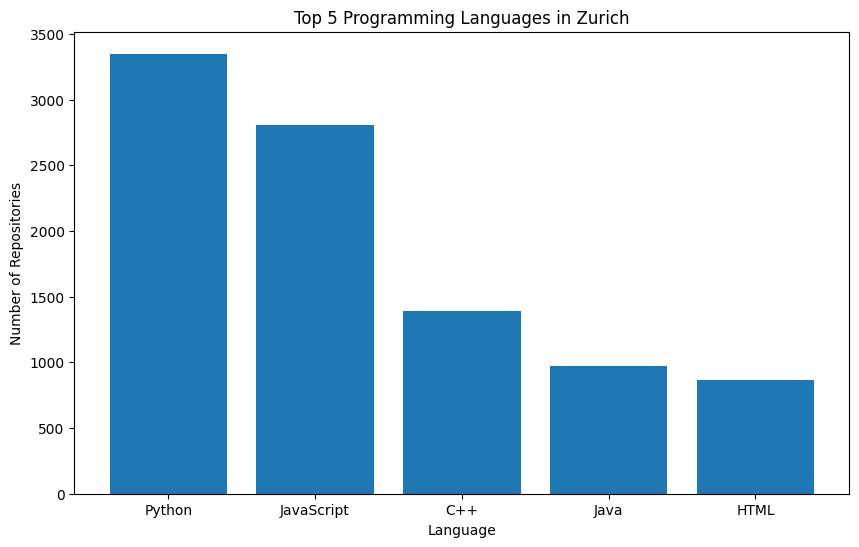

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

users_df = pd.read_csv('users1.csv')
repos_df = pd.read_csv('repositories1.csv')

languages = repos_df['language'].dropna().tolist()
language_counts = Counter(languages)
top_languages = language_counts.most_common(5)

plt.figure(figsize=(10, 6))
plt.bar([lang for lang, count in top_languages], [count for lang, count in top_languages])
plt.title('Top 5 Programming Languages in Zurich')
plt.xlabel('Language')
plt.ylabel('Number of Repositories')
plt.savefig('top_languages.png')

user_avg_stars = repos_df.groupby('login')['stargazers_count'].mean().sort_values(ascending=False)

correlation = users_df['public_repos'].corr(users_df['followers'])

print(f"Top 5 programming languages: {top_languages}")
print(f"User with highest average stars per repo: {user_avg_stars.index[0]} ({user_avg_stars.values[0]:.2f} stars)")
print(f"Correlation between public repos and followers: {correlation:.2f}")

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from scipy import stats

users_df = pd.read_csv('users.csv')
repos_df = pd.read_csv('repositories.csv')

top_followers = users_df.nlargest(5,'followers')['login'].tolist()
print("1.", ",".join(top_followers))

users_df['created_at'] = pd.to_datetime(users_df['created_at'])

earliest_users = users_df.nsmallest(5, 'created_at')['login'].tolist()
print("2.", ",".join(earliest_users))

top_licenses = repos_df['license_name'].value_counts().nlargest(3).index.tolist()
print("3.", ",".join(top_licenses))

users_df['company_clean'] = users_df['company'].fillna('')
users_df['company_clean'] = users_df['company_clean'].str.lower()
users_df['company_clean'] = users_df['company_clean'].str.replace('[^a-z0-9]', '')
company_counts = users_df[users_df['company_clean'] != '']['company_clean'].value_counts()
most_common_company = company_counts.index[0] if not company_counts.empty else ''
print("4.", most_common_company.upper())

most_popular_lang = repos_df['language'].value_counts().index[0]
print("5.", most_popular_lang)

users_after_2020 = users_df[pd.to_datetime(users_df['created_at']) > '2020-01-01']['login']
langs_after_2020 = repos_df[repos_df['login'].isin(users_after_2020)]['language'].value_counts()
second_popular_lang_2020 = langs_after_2020.index[1]
print("6.", second_popular_lang_2020)

lang_avg_stars = repos_df.groupby('language')['stargazers_count'].mean()
highest_avg_stars_lang = lang_avg_stars.idxmax()
print("7.", highest_avg_stars_lang)

users_df['leader_strength'] = users_df['followers'] / (1 + users_df['following'])
top_leader_strength = users_df.nlargest(5, 'leader_strength')['login'].tolist()
print("8.", ",".join(top_leader_strength))

corr_followers_repos = users_df['followers'].corr(users_df['public_repos'])
print(f"9. {corr_followers_repos:.3f}")

slope, _, _, _, _ = stats.linregress(users_df['public_repos'], users_df['followers'])
print(f"10. {slope:.3f}")

corr_projects_wiki = repos_df['has_projects'].astype(int).corr(repos_df['has_wiki'].astype(int))
print(f"11. {corr_projects_wiki:.3f}")

hireable_following = users_df[users_df['hireable'] == 'true']['following'].mean()
non_hireable_following = users_df[users_df['hireable'] != 'true']['following'].mean()
following_diff = hireable_following - non_hireable_following
print(f"12. {following_diff:.3f}")

users_df['bio_word_count'] = users_df['bio'].fillna('').str.split().str.len()
users_with_bio = users_df[users_df['bio_word_count'] > 0]
slope, _, _, _, _ = stats.linregress(users_with_bio['bio_word_count'], users_with_bio['followers'])
print(f"13. {slope:.3f}")

repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])
repos_df['is_weekend'] = repos_df['created_at'].dt.dayofweek.isin([5, 6])
weekend_repos = repos_df[repos_df['is_weekend']].groupby('login').size()
top_weekend_users = weekend_repos.nlargest(5).index.tolist()
print("14.", ",".join(top_weekend_users))

true_email_rate = users_df[users_df['hireable'] == 'true']['email'].notna().mean()
none_email_rate = users_df[users_df['hireable'] == 'none']['email'].notna().mean()
difference = true_email_rate - none_email_rate
print(f"15. {difference:.3f}")

users_df['surname'] = users_df['name'].fillna('').str.split().str[-1]
most_common_surname = users_df['surname'].value_counts().index[0]
surname_count = users_df['surname'].value_counts().max()
print(f"16. {surname_count}")

1. IDouble,wcandillon,TheOfficialFloW,Seldaek,twpayne
2. matthiask,floere,oscardelben,zdavatz,nominolo
3. mit,other,apache-2.0
4. GOOGLE
5. Python
6. JavaScript
7. Pug
8. riscv,bpasero,Seldaek,leggedrobotics,egamma
9. 0.066
10. 1.325
11. 0.363
12. -888.086
13. 39.404
14. kynan,yakky,devnoname120,Sadullah-TANRIKULU,JonnyBurger
15. 0.079
16. 3


In [ ]:
import pandas as pd
import re

def clean_company(company):
    if pd.isna(company) or company == '':
        return ''

    company = str(company).lower()

    # Remove special characters and extra spaces
    company = re.sub(r'[^\w\s]', '', company)
    company = company.strip()

    # Standardize common company names
    company_map = {
        'google': 'google',
        'microsoft': 'microsoft',
        'eth': 'eth zurich',
        'eth zurich': 'eth zurich',
        'ethz': 'eth zurich',
        'nvidia': 'nvidia'
    }

    for key, value in company_map.items():
        if key in company:
            return value

    return company

users_df['company_clean'] = users_df['company'].apply(clean_company)
company_counts = users_df[users_df['company_clean'] != '']['company_clean'].value_counts()
most_common_company = company_counts.index[0]

print("Most common company:", most_common_company)
print("\nTop 5 Company counts:")
print(company_counts.head())

Most common company: google

Top 5 Company counts:
company_clean
google         60
eth zurich     58
microsoft       9
nvidia          7
oracle labs     5
Name: count, dtype: int64


In [ ]:
correlation = repos_df['has_projects'].corr(repos_df['has_wiki'])
print(f"Correlation: {correlation:.3f}")

Correlation: 0.363


In [ ]:
users_df['bio_word_count'] = users_df['bio'].fillna('').str.split().str.len()
users_with_bio = users_df[users_df['bio_word_count'] > 0]
correlation = users_with_bio['bio_word_count'].corr(users_with_bio['followers'])
print(f"Correlation: {correlation:.3f}")

Correlation: 0.131


In [2]:
users_df['surname'] = users_df['name'].str.split().str[-1]
surname_counts = users_df['surname'].value_counts()
most_common_count = surname_counts.max()
most_common_surnames = surname_counts[surname_counts == most_common_count].index.tolist()
most_common_surnames.sort()
print(f"Most common surname(s): {', '.join(most_common_surnames)}")
print(f"Number of users with the most common surname: {most_common_count}")

Most common surname(s): Lab, Meier, Wang
Number of users with the most common surname: 3
